# Linear regression with PyTorch

## Import libraries

In [102]:
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
from sklearn.model_selection import train_test_split

## Generate dataset

Сгенерируем датасет для линейной регрессии длиной 20000. Таргет будет рассчитан по формуле $\sin(x-2y)\exp ^{-(2x+y)^2}$

In [19]:
# number of samples
n = 20000
# set seed
torch.manual_seed(77)
# generate dataset
dataset = torch.FloatTensor(n, 2).cuda()
dataset.uniform_(-10, 10)
x = dataset[:, 0]
y = dataset[:, 1]
# generate target
target = torch.sin(x + 2*y) * torch.exp(-(2*x + y)**2)
target = target.view(n, 1)

## Pre-processing

In [21]:
x_train, x_test, y_train, y_test = train_test_split(dataset, target, test_size=0.15, random_state=77)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=77)

## Create model

In [22]:
class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(2, 1)
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

## Select model

In [32]:
learn_rates = [0.001, 0.01]
val_scores = []
models = []
for lr in learn_rates:
    print('Learning rate:', lr)
    model = LinearRegressionModel().cuda()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    n_epoch = 200
    for epoch in tqdm(range(n_epoch)):

        # Forward pass: Compute predicted y by passing
        # x to the model
        y_pred = model(x_train)

        # Compute and print loss
        loss = criterion(y_pred, y_train)

        # Zero gradients, perform a backward pass,
        # and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    models.append(model)
    val_score = criterion(model(x_val), y_val)
    val_scores.append(val_score)
    print('Train loss', loss)
    print('Validation loss', val_score)

Learning rate: 0.001


100%|██████████| 200/200 [00:00<00:00, 1579.65it/s]


Train loss tensor(0.1265, device='cuda:0', grad_fn=<MseLossBackward0>)
Validation loss tensor(0.1251, device='cuda:0', grad_fn=<MseLossBackward0>)
Learning rate: 0.01


100%|██████████| 200/200 [00:00<00:00, 1643.53it/s]

Train loss tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)
Validation loss tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)


Learning rate равный 0.01 показал лучший результат на валидационной выборке, поэтому мы будем оценивать модель, обученную на нем.

In [93]:
model = models[1]

## Results

Проверим чему равна метрика на тесте:

In [33]:
y_pred = models[1](x_test)
mse = criterion(y_pred, y_test)
mse

tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

Для лучшего понимания картины посмотрим на распределение ошибок.

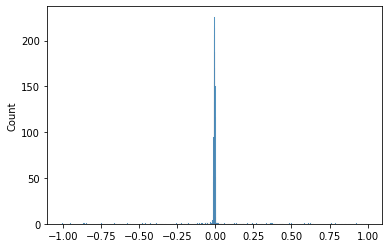

In [103]:
def to_np(tensor):
  return tensor.cpu().detach().numpy()
err = y_test - y_pred
err = to_np(err).flatten()
sns.histplot(x=err)
plt.show()

Как мы видим для большинства случаев ошибка близка к нулю. 

Построим графики оригинальной функции и функции предсказанной линейной моделью.

In [109]:
# extract model results
xy_weights = to_np(model.linear.weight)[0]
wx, wy = xy_weights[0], xy_weights[1]
print("Coefficients: ", wx, wy)
intercept = float(model.linear.bias)
print("Intercept:", intercept)

Coefficients:  -0.00035955367 0.0007081941
Intercept: 0.004353610798716545


In [119]:
size = 200
X, Y = np.linspace(-10, 10, size), np.linspace(-10, 10, size)
Z = np.zeros((size, size))
Z_pred = np.zeros((size, size))
for i, x in enumerate(X):
  for j, y in enumerate(Y):
    Z[i, j] = np.sin(x + 2*y) * np.exp(-(2*x + y)**2)
    Z_pred [i, j] = wx*x + wy*y + intercept

In [122]:
fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z, opacity=0.5),
                      go.Surface(x=X, y=Y, z=Z_pred, showscale=False)])
fig.update_layout(title='f(x,y) vs. predicted f(x,y)', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()